In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [2]:
gdf_zones = gpd.read_file('../charger_network_analysis/Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [3]:
# Loading Info

graph = src.graph.graph_from_json('graph.json')

In [4]:
parameters = json.load(open('CEC/parameters_cec_router_bolt.json', 'rb'))

In [5]:
graph = src.router.assign_rng(graph, seed = parameters['rng_seed'])

In [6]:
deep_reload(src)

graph = src.router.assign_vehicle(graph, parameters['vehicles'])

In [7]:
keep_nodes = [k for k, v in graph._node.items() if v['vehicle']]
len(keep_nodes)

612

In [116]:
sg = src.graph.subgraph(graph, np.concatenate((keep_nodes, parameters['depot_nodes'])))

In [118]:
deep_reload(src)

objectives = {'time': np.inf, 'length': np.inf}

sg = src.savings.add_depot_legs(sg, parameters['depot_nodes'], objectives)

In [121]:
deep_reload(src)

shape = (30, )

charger_time = src.rng.Charger_Time(size = shape)

for node in sg._node.values():

    charger_time.assign(node)

In [21]:
shape = (30, )

mns = src.rng.MultiNormalSample([.6, .99], [.25, .05], [.3, .7])

for source, links in sg._adj.items():
    for target, link in links.items():

        mult = 1 / np.clip(mns.random(shape), 0, 1.05)
        link['time'] = link['time'] / mult
        link['length'] = link['length'] * np.ones(shape)

In [22]:
for node, node_data in sg._node.items():
    
    mult = 1 / np.clip(mns.random(shape), 0, 1.05)
    node_data['depot_leg']['time'] = node_data['depot_leg']['time'] / mult
    node_data['depot_leg']['length'] = node_data['depot_leg']['length'] * np.ones(shape)

In [25]:
kwargs = {
    'pb_kwargs': {
        'freq': 1000,
    }
}

final_routes = []

for vehicle_name, vehicle in parameters['vehicles'].items():

    objectives = {
        'time': {
            'route': vehicle['route_bounds']['time'],
            'leg': vehicle['leg_bounds']['time'],
            'weight': 1,
        },
        'length': {
            'route': vehicle['route_bounds']['length'],
            'leg': vehicle['leg_bounds']['length'],
            'weight': 0,
        }
    }

    routes, route_values, success = src.savings_stochastic.savings(
        sg, objectives, **kwargs,
    )

    routes = src.router.route_information(sg, routes, parameters['route_fields'])

    full_routes = []
    
    for idx, route in enumerate(routes):

        if len(route['nodes']) > 3 or (vehicle_name == list(parameters['vehicles'].keys())[-1]):
    
            route['vehicle'] = vehicle_name
            route['time'] = route_values[idx]['time']
            route['length'] = route_values[idx]['length']    
            full_routes.append(route)

    all_nodes = np.array(list(sg.nodes))
    nodes_visited = np.unique(np.concatenate([r['nodes'] for r in full_routes]))
    nodes_not_visited = np.setdiff1d(all_nodes, nodes_visited[nodes_visited < 1000000000])

    final_routes.extend(full_routes)

    sg = src.graph.subgraph(sg, nodes_not_visited)

 [---------->] (1/1) 100.00%, 254200.24 it/s, 0.00 s elapsed, 0.00 s remaining

In [85]:
nodes_visited = np.concatenate([r['nodes'] for r in final_routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)
len(final_routes), len(nodes_visited), len(np.unique(nodes_visited))

(107, 823, 612)

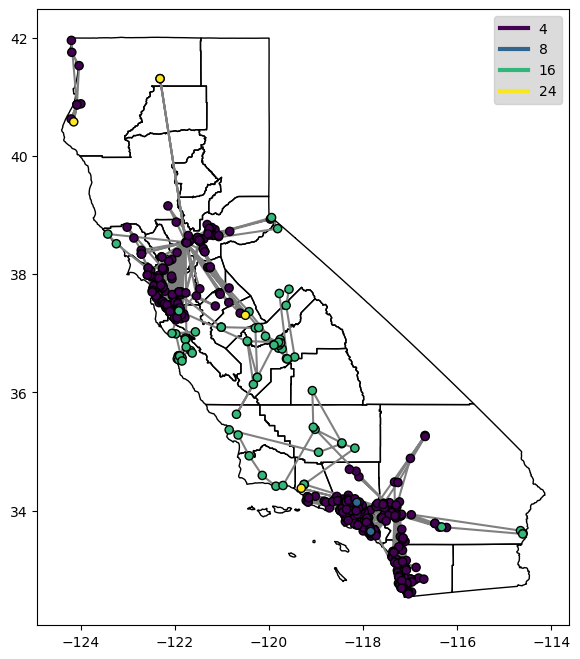

In [97]:
deep_reload(src)

# routes = final_routes

routes = np.random.choice(final_routes, len(final_routes), replace = False)

node_to_idx, idx_to_node = src.router.assignments(list(graph.nodes))

raw_routes = [[node_to_idx[n] for n in r['nodes']] for r in routes]

for route in routes:
    # print(route['vehicle'])
    if ' 4 ' in route['vehicle']:
        vn = .0

    elif '8' in route['vehicle']:
        vn = .33

    elif '16' in route['vehicle']:
        vn = .66

    elif '24' in route['vehicle']:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        graph._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.ReturnColorMap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)